In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from pprint import pprint
import spacy
from spacy.tokenizer import _get_regex_pattern
import nltk
from nltk.corpus import stopwords
import re
from spacy.matcher import Matcher
import spacy
from spacymoji import Emoji
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity
import string
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim_models as gensimvis

## Tinder Swindler 100k Tweets

In [8]:
# load the dataset
file = './TinderSwindlerVersion2.csv'
df = pd.read_csv(file)

In [9]:
df.head(10)

,user_name,user_location,user_created,user_followers,user_verified,date,text,source,is_retweet
0,globalnode.saito 🟥🐳🐈‍⬛,Travelling the World on Web3,2009-06-03 20:18:22+00:00,768,False,2022-02-09 17:09:22+00:00,"@T1gmee Tinder Swindler, off Netflix",Twitter for iPhone,False
1,Ungovernable 🇧🇮,NaN,2011-09-04 22:46:26+00:00,385,False,2022-02-09 17:09:18+00:00,"#tinderswindler , basically homeboy got away w...",Twitter for iPhone,False
2,Adefolake,NaN,2009-06-02 14:18:44+00:00,1994,False,2022-02-09 17:09:17+00:00,Not the tinder swindler becoming a TIk Tok sta...,Twitter for iPhone,False
3,✧ ☽,Noord-Brabant,2012-02-12 07:35:26+00:00,336,False,2022-02-09 17:09:07+00:00,Why isn’t Shimon Hayut in jail ????? #thetinde...,Twitter for iPhone,False
4,chivo. 🥶,PG/MD,2010-03-22 21:23:17+00:00,1046,False,2022-02-09 17:09:06+00:00,the tinder swindler a sick nigga 😂😂,Twitter Web App,False
5,kira,"Toronto, Ontario",2010-07-02 12:50:53+00:00,362,False,2022-02-09 17:09:03+00:00,No those women on the Tinder swindler pissed m...,Twitter for iPhone,False
6,fogmistress698,NaN,2020-05-05 08:47:57+00:00,210,False,2022-02-09 17:08:55+00:00,This manipulation is how scammers pull you in ...,Twitter Web App,False
7,melraunch,"East, England",2019-05-24 23:18:01+00:00,3268,False,2022-02-09 17:08:45+00:00,@robertstweets1 @DistantFixed I waited for him...,Twitter for iPhone,False
8,Pamela Power,"Johannesburg, South Africa",2009-07-10 12:51:24+00:00,6306,False,2022-02-09 17:08:41+00:00,Hmmm...he's like the #tinderswindler https://t...,Twitter for Android,False
9,CaliMcCormac,NaN,2022-02-09 16:48:06+00:00,0,False,2022-02-09 17:08:40+00:00,Wow just watching the Twitter Swindler and it ...,Twitter for iPhone,False


### Data Cleansing

In [10]:
df.isna().sum()

user_name             5
user_location     18481
user_created          0
user_followers        0
user_verified         0
date                  0
text                  0
source                0
is_retweet            0
dtype: int64

In [11]:
df["user_name"].fillna('unknown', inplace=True)
df["user_location"].fillna('unknown', inplace=True)

In [12]:
# Remove urls from tweets
df.text = df.text.apply(lambda text: re.sub(r'http\S+|http', '', text))

In [13]:
df = df[df.is_retweet != True]

In [14]:
df.describe(include= "O").T

,count,unique,top,freq
user_name,76213,49767,.,196
user_location,76213,17911,unknown,18485
user_created,76213,54501,2020-10-06 00:15:38+00:00,160
date,76213,70999,2022-02-07 21:13:06+00:00,5
text,76213,73948,The Tinder Swindler,69
source,76213,210,Twitter for iPhone,47828


In [15]:
# df_sample = df.sample(10000)
df_sample = df

### Load Spacy and init stop words

In [16]:
nltk.download('stopwords')

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe("emoji", first=True)

# get default pattern for tokens that don't get split
re_token_match = _get_regex_pattern(nlp.Defaults.token_match)
# add patterns for hashtags and in-word hyphens
re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"

# overwrite token_match function of the tokenizer
nlp.tokenizer.token_match = re.compile(re_token_match).match

stop_words = stopwords.words('english')


<>:9: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \w
/var/folders/vv/xxr9dlwd5lx3_s4nm4vw3nj5ggqq15/T/ipykernel_59409/238681695.py:9: DeprecationWarning: invalid escape sequence \w
  re_token_match = f"({re_token_match}|#\w+|\w+-\w+)"
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


In [17]:
# extend stop words if needed
stop_words.extend(['\n', "\n\n",'hi','\n','\n\n', '&amp;', ' ', '.','…','…', '-', 'got', "it's", 'it’s', "i'm", 'i’m', 'im', 'want', 'like', '$', '@'])

In [18]:
no_stop_words = [
    'not'
]

for w in no_stop_words:
    nlp.vocab[w].is_stop = False

#### Create docs via spacy
Follow along [this](https://towardsdatascience.com/text-preprocessing-steps-and-universal-pipeline-94233cb6725a) guide for more details about each single step

In [19]:
# custom extended abbreviations
custom_abbreviations = {"bdrm": "bedroom"}

def normalize(text):
    # choosing BrE variety here since majority of posts are from the UK
        try:
            return ' '.join(normalise(text, variety="BrE", user_abbrevs=custom_abbreviations, verbose=False))
        except:
            return text

In [20]:
df_sample.text.apply(normalize)

0                     @T1gmee Tinder Swindler, off Netflix
1        #tinderswindler , basically homeboy got away w...
2        Not the tinder swindler becoming a TIk Tok sta...
3        Why isn’t Shimon Hayut in jail ????? #thetinde...
4                      the tinder swindler a sick nigga 😂😂
                               ...                        
76208    Woman conned of over £200,000 by ‘Tinder swind...
76209    On the afternoon show @BBCRadioLondon till 6pm...
76210    group chat killing me today bc I point out a k...
76211    important releases this month. \n\n- Loop Lape...
76212    Woman conned of over £200,000 by ‘Tinder swind...
Name: text, Length: 76213, dtype: object

In [21]:
# create docs list with nlp
docs = [d for d in nlp.pipe(df_sample.text, n_process=6)]

In [22]:
def remove_stop_words(doc):
    return [t for t in doc if not t.is_stop]

In [23]:
# python based removal
def remove_punct(doc):
    return [t for t in doc if t.text not in string.punctuation]

In [24]:
def remove_hashtag(doc):
    return [t for t in doc if not t.text.startswith('#')]

In [25]:
def remove_annotations(doc):
    return [t for t in doc if not t.text.startswith('@')]

In [26]:
def remove_linebreaks(doc):
    return [t for t in doc if not "\n" in t.text]

In [27]:
def lemmatize(doc):
    return ' '.join([t.lemma_ for t in doc])

In [28]:
def lemmatize_token(doc):
    return [t.lemma_ for t in doc]

In [29]:
def preprocess_text(doc, keep_token):
        removed_punct = remove_punct(doc)
        removed_stop_words = remove_stop_words(removed_punct)
        removed_hashtag = remove_hashtag(removed_stop_words)
        removed_annotations = remove_annotations(removed_hashtag)
        removed_linebreaks = remove_linebreaks(removed_annotations)
        if keep_token:
                return lemmatize_token(removed_linebreaks)
        else:
                return lemmatize(removed_linebreaks)

In [30]:
pre_proccesed_texts = [preprocess_text(doc, False) for doc in docs]

In [31]:
pre_proccesed_texts[0]

'Tinder Swindler Netflix'

In [32]:
pre_proccesed_docs = [preprocess_text(doc, True) for doc in docs]

### Get Hashtags and Emoji

In [33]:
matcher = Matcher(nlp.vocab)
pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]
matcher.add('HASHTAG', [pattern])

def getHashtags(doc):
    matches = matcher(doc)
    hashtags = []
    for match_id, start, end in matches:
        span = doc[start:end]  # The matched span
        text = re.sub('[^A-Za-z0-9_-]+', '', span.text)
        hashtags.append(text)
    return hashtags

# getHashtags(docs[15])
# >>> ['tinderswindler']

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
/var/folders/vv/xxr9dlwd5lx3_s4nm4vw3nj5ggqq15/T/ipykernel_59409/1982691143.py:2: DeprecationWarning: invalid escape sequence \w
  pattern = [{"TEXT": {"REGEX": "^#\w+|\w+-\w+"}}]


In [34]:
# create list of hastags
hashtags = [item for sublist in list(getHashtags(doc) for doc in docs) for item in sublist]

In [35]:
counter = Counter()

for tag in hashtags:
    counter[tag] += 1

top_15_hashtags = counter.most_common(15)

In [36]:
df_hashtags = pd.DataFrame.from_records(top_15_hashtags, columns =['hashtag', 'count'])

In [37]:
df_hashtags

,hashtag,count
0,tinderswindler,15866
1,TheTinderSwindler,10852
2,TinderSwindler,2617
3,Netflix,562
4,simonleviev,251
5,thetinderswindler,205
6,netflix,133
7,TindlerSwindler,128
8,Tinderswindler,78
9,Tinder,74


In [38]:
def getEmoji(doc):
    emojis = set()
    if doc._.has_emoji:
        for emoji in doc._.emoji:
                emojis.add((emoji[0],emoji[2])) 

    return emojis

In [39]:
# create list of emojis
emojis = [item for sublist in list(getEmoji(doc) for doc in docs) for item in sublist]

In [40]:
counter = Counter()

for emoji in emojis:
    counter[emoji] += 1

top_15_emoji = (counter.most_common(15))

In [41]:
top_15_emoji

[(('😂', 'face with tears of joy'), 4969),
 (('😭', 'loudly crying face'), 3214),
 (('🤣', 'rolling on the floor laughing'), 2394),
 (('🤯', 'exploding head'), 1028),
 (('💀', 'skull'), 829),
 (('😳', 'flushed face'), 754),
 (('😩', 'weary face'), 664),
 (('🥴', 'woozy face'), 414),
 (('😅', 'grinning face with sweat'), 413),
 (('👀', 'eyes'), 370),
 (('🚩', 'triangular flag'), 339),
 (('😱', 'face screaming in fear'), 329),
 (('🤔', 'thinking face'), 286),
 (('🔥', 'fire'), 218),
 (('😮', 'face with open mouth'), 194)]

In [42]:
flatted_emojis = []

for emoji in top_15_emoji:
    flatted_emoji = []
    for entry in emoji:
        if hasattr(entry, '__iter__'):
            for i in entry:
                flatted_emoji.append(i)
        else:
            flatted_emoji.append(entry)
    flatted_emojis.append(flatted_emoji)

print(flatted_emojis)
    
   


[['😂', 'face with tears of joy', 4969], ['😭', 'loudly crying face', 3214], ['🤣', 'rolling on the floor laughing', 2394], ['🤯', 'exploding head', 1028], ['💀', 'skull', 829], ['😳', 'flushed face', 754], ['😩', 'weary face', 664], ['🥴', 'woozy face', 414], ['😅', 'grinning face with sweat', 413], ['👀', 'eyes', 370], ['🚩', 'triangular flag', 339], ['😱', 'face screaming in fear', 329], ['🤔', 'thinking face', 286], ['🔥', 'fire', 218], ['😮', 'face with open mouth', 194]]


In [43]:
# create DataFrame using data
df_emoji = pd.DataFrame.from_records(flatted_emojis, columns =['emoji',"desc", 'count'])

In [44]:
df_emoji

,emoji,desc,count
0,😂,face with tears of joy,4969
1,😭,loudly crying face,3214
2,🤣,rolling on the floor laughing,2394
3,🤯,exploding head,1028
4,💀,skull,829
5,😳,flushed face,754
6,😩,weary face,664
7,🥴,woozy face,414
8,😅,grinning face with sweat,413
9,👀,eyes,370


### First explorative Analysis

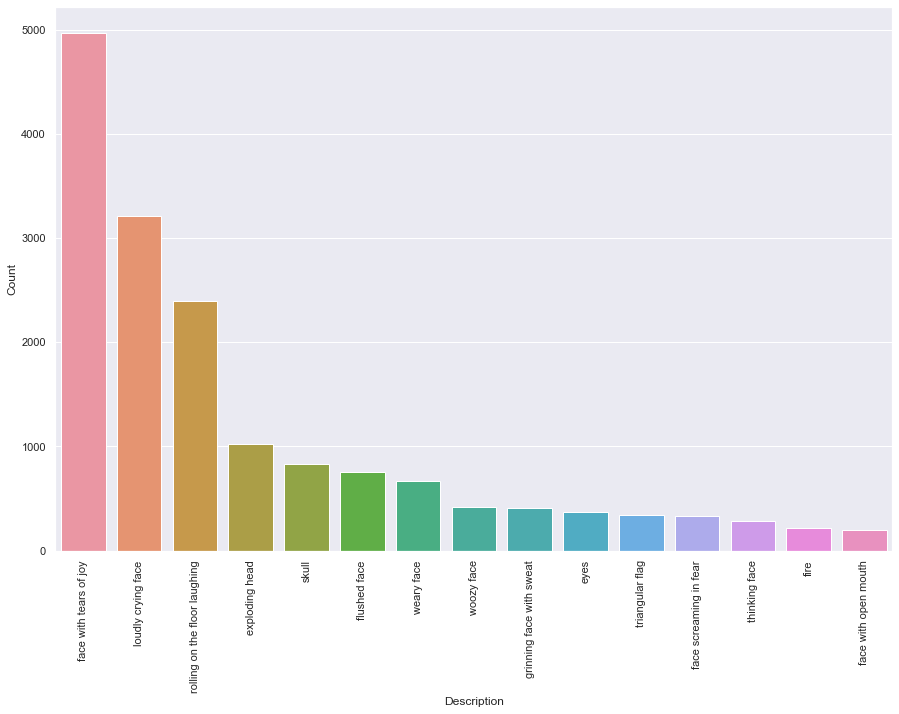

In [45]:
from pathlib import Path
import matplotlib as mpl

plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="desc",y="count", data=df_emoji)
ax.set_xlabel("Description")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


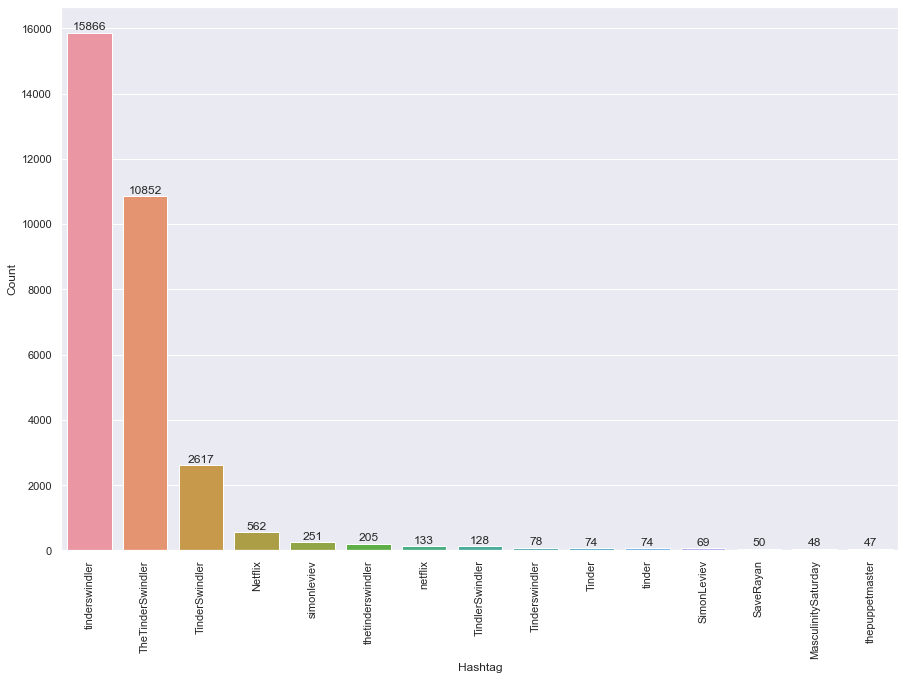

In [46]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="hashtag",y="count", data=df_hashtags)


for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Hashtag")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


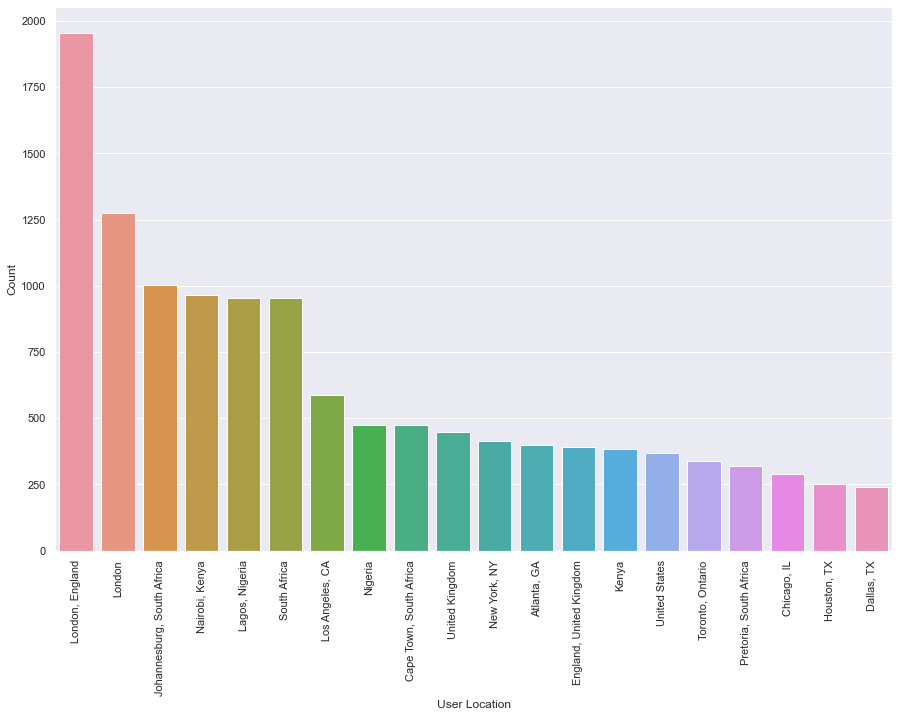

In [47]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.countplot(x="user_location", data=df[df["user_location"] != "unknown"], order=df[df["user_location"] != "unknown"]['user_location'].value_counts().index[0:20])
ax.set_xlabel("User Location")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)

In [48]:
df['datetime_date'] = pd.to_datetime(df['date']).dt.date

In [49]:
df_datecount = df.groupby(by="datetime_date")['datetime_date'].count().reset_index(name="count")

In [50]:
df_datecount

,datetime_date,count
0,2022-02-01,80
1,2022-02-02,3130
2,2022-02-03,6725
3,2022-02-04,9080
4,2022-02-05,13420
5,2022-02-06,14831
6,2022-02-07,11798
7,2022-02-08,11042
8,2022-02-09,6107


Text(0.5, 0, 'Date')

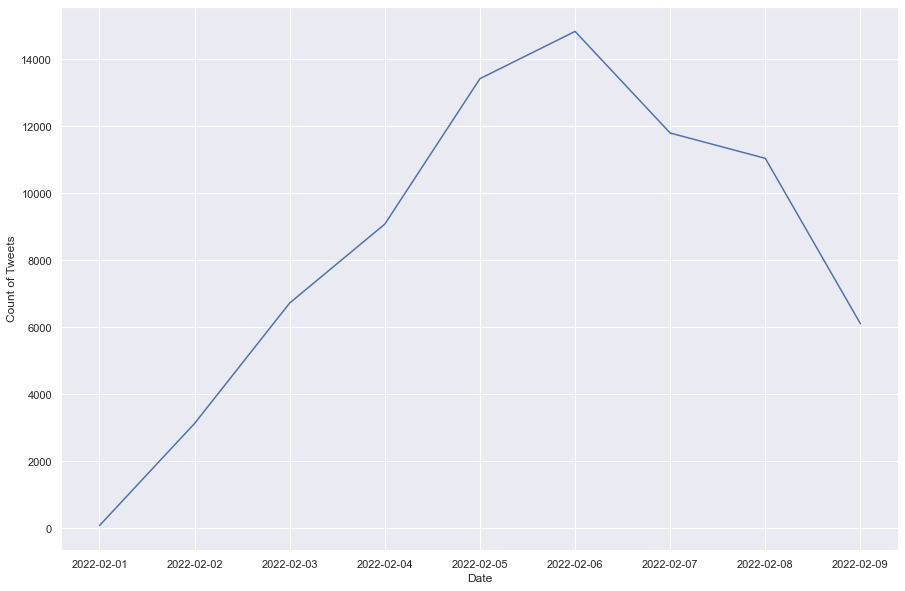

In [51]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.lineplot(data=df_datecount,x=df_datecount["datetime_date"], y=df_datecount['count'].value_counts().index)
ax.set_ylabel("Count of Tweets")
ax.set_xlabel("Date")

The film was released on Netflix on February 2, 2022

In [52]:
# word count
words = [item for sublist in pre_proccesed_docs for item in sublist]
cv = CountVectorizer().fit(words)
texts_count = cv.transform(words)
sum_words = texts_count.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)


In [53]:
top_20_words = words_freq[:20]

In [54]:
df_word_freq = pd.DataFrame.from_records(top_20_words, columns = ['word', 'count'])

In [55]:
df_word_freq

,word,count
0,swindler,39028
1,tinder,37420
2,watch,14660
3,simon,6845
4,woman,6783
5,netflix,6291
6,man,5746
7,like,4313
8,not,3787
9,guy,3567


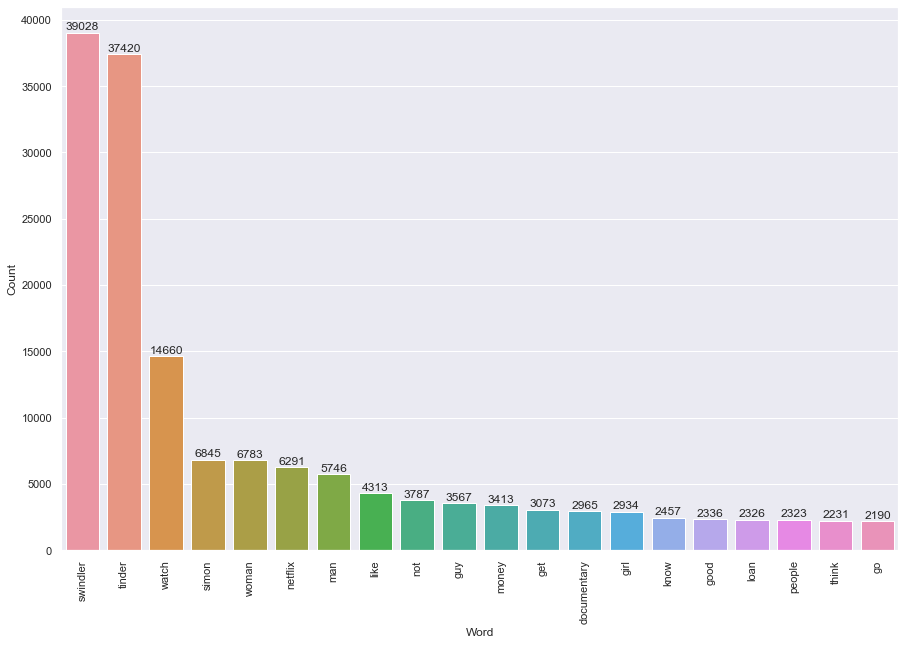

In [56]:
plt.figure(figsize=(15,10))
sns.set(style="darkgrid")
ax = sns.barplot(x="word",y="count", data=df_word_freq)

for p in ax.patches:
    count = f'{p.get_height():.0f}\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(count, (x, y), ha='center', va='center')

ax.set_xlabel("Word")
ax.set_ylabel("Count")
ax.tick_params(axis='x', rotation=90)


### Sentiment Analysis

In [57]:
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [58]:
preprocess_docs_sentiment = [remove_punct(remove_linebreaks(remove_annotations(remove_hashtag(doc)))) for doc in docs]

In [59]:
preprocess_text_sentiment = []
for doc in preprocess_docs_sentiment:
    doc_text = ""
    for word in doc:
        doc_text = doc_text + word.text
        if doc.index(word) +1 < len(doc):
            doc_text = doc_text + " "
    preprocess_text_sentiment.append(doc_text)

In [60]:
preprocess_text_sentiment[:5]

['Tinder Swindler off Netflix',
 'basically homeboy got away with it',
 'Not the tinder swindler becoming a TIk Tok star 🙄',
 'Why is n’t Shimon Hayut in jail',
 'the tinder swindler a sick nigga 😂 😂']

In [61]:
df_preprocessed_text = pd.DataFrame(preprocess_text_sentiment, columns=['text'])

In [62]:
df_preprocessed_text[['polarity', 'subjectivity']] = df_preprocessed_text['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

In [63]:
for index, row in df_preprocessed_text['text'].items():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        df_preprocessed_text.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        df_preprocessed_text.loc[index, 'sentiment'] = "positive"
    else:
        df_preprocessed_text.loc[index, 'sentiment'] = "neutral"
    df_preprocessed_text.loc[index, 'neg'] = neg
    df_preprocessed_text.loc[index, 'neu'] = neu
    df_preprocessed_text.loc[index, 'pos'] = pos
    df_preprocessed_text.loc[index, 'compound'] = comp

KeyboardInterrupt: 

In [ ]:
df_preprocessed_text.head()

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
0,Tinder Swindler off Netflix,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
1,basically homeboy got away with it,0.000000,0.000000,neutral,0.000,1.000,0.000,0.0000
2,Not the tinder swindler becoming a TIk Tok star 🙄,0.450000,0.850000,neutral,0.000,1.000,0.000,0.0000
3,Why is n’t Shimon Hayut in jail,-0.100000,0.000000,neutral,0.000,1.000,0.000,0.0000
4,the tinder swindler a sick nigga 😂 😂,-0.714286,0.857143,positive,0.276,0.428,0.296,0.3612


In [ ]:
df_preprocessed_text[(df_preprocessed_text["pos"] > 0.8) & (df_preprocessed_text["polarity"] > 0.5)]

,text,polarity,subjectivity,sentiment,neg,neu,pos,compound
1503,👌 💜 Brilliant marketing Well spotted Love th...,0.700000,0.80,positive,0.0,0.197,0.803,0.9658
2100,So perfect 👌 😀,1.000000,1.00,positive,0.0,0.132,0.868,0.9212
2571,Brilliant,0.900000,1.00,positive,0.0,0.000,1.000,0.5859
6085,Brilliant,0.900000,1.00,positive,0.0,0.000,1.000,0.5859
7041,Lol so funny eerrr lol,0.616667,0.80,positive,0.0,0.181,0.819,0.8425
22820,love wise ha,0.600000,0.75,positive,0.0,0.000,1.000,0.8658
24865,Best part,1.000000,0.30,positive,0.0,0.192,0.808,0.6369
43512,Lmao i LOVE Ayleen,0.550000,0.80,positive,0.0,0.185,0.815,0.8700
51103,Lol Simon won,0.800000,0.70,positive,0.0,0.133,0.867,0.7579
52157,Please be nice,0.600000,1.00,positive,0.0,0.164,0.836,0.6249


In [ ]:
df_preprocessed_text.iloc[1503].text

'👌 💜 Brilliant marketing Well spotted   Love that movie'

In [ ]:
df_preprocessed_text_negative = df_preprocessed_text[df_preprocessed_text["sentiment"]=="negative"]
df_preprocessed_text_positive = df_preprocessed_text[df_preprocessed_text["sentiment"]=="positive"]
df_preprocessed_text_neutral = df_preprocessed_text[df_preprocessed_text["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
df_sentiment = count_values_in_column(df_preprocessed_text,"sentiment")

print(df_sentiment)

          Total  Percentage
positive  28173       36.97
negative  25462       33.41
neutral   22578       29.62


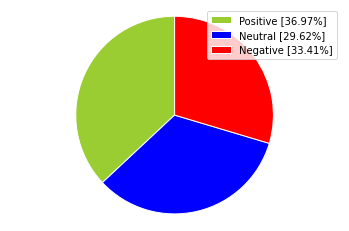

In [ ]:
labels = ['Positive ['+str(df_sentiment['Percentage']['positive'])+'%]' , 'Neutral ['+str(df_sentiment['Percentage']['neutral'])+'%]','Negative ['+str(df_sentiment['Percentage']['negative'])+'%]']
sizes = df_sentiment['Percentage']
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.axis('equal')
plt.show()

### LDA

#### Prepare raw text data for lda

In [64]:
import emoji

In [65]:
# prepare text for lda model
df_lda = pd.DataFrame(df_sample['text'], columns=["text"])
# Remove punctuation
df_lda['text_processed_cleaned'] = df_lda['text'].map(lambda x: re.sub('[,\.!?\n]', '', x))
# Remove hashtags
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.sub('#\w+|\w+-\w+', '', x))
# Remove annotations
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.sub('@\w+|\w+-\w+', '', x))
# Remove emojis
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: "".join([c for c in x if c not in emoji.UNICODE_EMOJI]))
# Remove linebreaks
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: x.replace('\n', ' '))
# Convert the titles to lowercase
df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: x.lower())
# Print out the first rows of df_lda
df_lda.head()

<>:4: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \.
<>:6: DeprecationWarning: invalid escape sequence \w
<>:8: DeprecationWarning: invalid escape sequence \w
/var/folders/vv/xxr9dlwd5lx3_s4nm4vw3nj5ggqq15/T/ipykernel_59409/500708818.py:4: DeprecationWarning: invalid escape sequence \.
  df_lda['text_processed_cleaned'] = df_lda['text'].map(lambda x: re.sub('[,\.!?\n]', '', x))
/var/folders/vv/xxr9dlwd5lx3_s4nm4vw3nj5ggqq15/T/ipykernel_59409/500708818.py:6: DeprecationWarning: invalid escape sequence \w
  df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.sub('#\w+|\w+-\w+', '', x))
/var/folders/vv/xxr9dlwd5lx3_s4nm4vw3nj5ggqq15/T/ipykernel_59409/500708818.py:8: DeprecationWarning: invalid escape sequence \w
  df_lda['text_processed_cleaned'] = df_lda['text_processed_cleaned'].map(lambda x: re.su

,text,text_processed_cleaned
0,"@T1gmee Tinder Swindler, off Netflix",tinder swindler off netflix
1,"#tinderswindler , basically homeboy got away w...",basically homeboy got away with it
2,Not the tinder swindler becoming a TIk Tok sta...,not the tinder swindler becoming a tik tok star
3,Why isn’t Shimon Hayut in jail ????? #thetinde...,why isn’t shimon hayut in jail
4,the tinder swindler a sick nigga 😂😂,the tinder swindler a sick nigga


#### Tokenize text

In [66]:

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
data = df_lda.text_processed_cleaned.values.tolist()
data_words = list(sent_to_words(data))

print(data_words[:2][1][:30])

/Users/akneis/git/notebooks/text-analytics/lib/python3.8/site-packages/gensim/matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


['basically', 'homeboy', 'got', 'away', 'with', 'it']


#### Buil bigrams and trigrams models

In [67]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

#### Remove Stopwords, Make Bigrams and Lemmatize

In [68]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [69]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['tinder', 'swindler']]


#### Data Transformation: Corpus and Dictionary

In [70]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1)]]


In [71]:
num_topics = 6

In [72]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

In [73]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.056*"girl" + 0.030*"enemy" + 0.021*"get" + 0.018*"say" + 0.017*"sorry" + '
  '0.013*"send" + 0.013*"go" + 0.012*"level" + 0.012*"whole" + 0.012*"money"'),
 (1,
  '0.053*"still" + 0.033*"woman" + 0.033*"life" + 0.031*"man" + 0.025*"live" + '
  '0.023*"pay" + 0.021*"free" + 0.020*"end" + 0.020*"believe" + 0.017*"guy"'),
 (2,
  '0.234*"tinder" + 0.232*"swindler" + 0.124*"watch" + 0.021*"netflix" + '
  '0.018*"documentary" + 0.011*"see" + 0.010*"go" + 0.009*"guy" + '
  '0.008*"finish" + 0.008*"movie"'),
 (3,
  '0.043*"man" + 0.040*"money" + 0.040*"take" + 0.035*"loan" + 0.028*"give" + '
  '0.025*"ask" + 0.022*"woman" + 0.019*"never" + 0.017*"billionaire" + '
  '0.013*"get"'),
 (4,
  '0.049*"woman" + 0.032*"love" + 0.020*"people" + 0.018*"bad" + 0.018*"show" '
  '+ 0.017*"feel" + 0.016*"go" + 0.016*"scamme" + 0.015*"date" + 0.014*"scam"'),
 (5,
  '0.126*"swindler" + 0.119*"tinder" + 0.030*"wild" + 0.028*"crazy" + '
  '0.020*"shit" + 0.017*"see" + 0.017*"story" + 0.014*"actually" +

In [74]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.3515453198249037


#### Calculate Coherence Score

In [75]:
from gensim import models

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics,
                                           random_state=100,
                                           chunksize=100,
                                           passes=10) 
                                          
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [76]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=20, step=1)
# Show graph
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

KeyboardInterrupt: 

In [77]:
# Visualize the topics

import pyLDAvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/akneis/git/notebooks/text-analytics/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.313439 -0.035306       1        1  27.988807
3     -0.153394 -0.100539       2        1  17.219575
5      0.263618  0.007914       3        1  15.334259
4     -0.155311 -0.032503       4        1  14.531240
1     -0.114718  0.338121       5        1  13.222792
0     -0.153634 -0.177687       6        1  11.703327, topic_info=         Term          Freq         Total Category  logprob  loglift
0    swindler  32804.000000  32804.000000  Default  30.0000  30.0000
1      tinder  32676.000000  32676.000000  Default  29.0000  29.0000
36      watch  13536.000000  13536.000000  Default  28.0000  28.0000
47      still   2730.000000   2730.000000  Default  27.0000  27.0000
138      girl   2966.000000   2966.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
85       feel    355.928238   1344.675990   Topic6  -4.8529   0.8161
16      woman    425.550549   6871.157730   Topic6  -4.6742  -0.6364
128     start    280.525725    928.996773   Topic6  -5.0909   0.9479
172    really    279.955385   2076.338939   Topic6  -5.0930   0.1416
61        guy    276.489200   3361.184364   Topic6  -5.1054  -0.3526

[349 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
659       3  0.318076  absolutely
659       5  0.680389  absolutely
579       2  0.884326     account
579       6  0.110949     account
348       4  0.995846         act
...     ...       ...         ...
301       1  0.002388        year
301       3  0.014329        year
301       4  0.981525        year
64        1  0.988488   yesterday
211       1  0.997973         yet

[471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 5, 2, 1])